In [1]:
from irbasis_util.four_point_ph_view import *
from irbasis_util.internal import *
from irbasis_util.regression import *
from irbasis_util.tensor_regression import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#padding on the y axis between label and axis
plt.rcParams['ytick.major.pad']='10'

dpi_out = 400
fig_width = 3.39
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_height = fig_width*golden_mean # height in inches
MAX_HEIGHT_INCHES = 8.0
if fig_height > MAX_HEIGHT_INCHES:
    print("WARNING: fig_height too large:" + fig_height + 
          "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
    fig_height = MAX_HEIGHT_INCHES
#fig, ax = plt.subplots(figsize = (fig_width, fig_height), frameon=True)
small_tick_size = 8
small_label_size = 8

In [3]:
# Implementation of Rohringer et al. () 2012)
def _delta(i, j):
    if i==j:
        return 1
    else:
        return 0

def _F_ph(U, beta, n, np, m):
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    r1 = nu + omega
    r2 = nu_p + omega
    tmp = 1. / (nu * r1 * r2 * nu_p)
    Fuu = (-0.25 * beta * (U**2) * (_delta(n,np) - _delta(m,0)) *
               (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    t1 = 0.125 * (U**3) * (nu**2 + r1**2 + r2**2 + nu_p**2) * tmp
    t2 = (3.0 / 16.0) * (U**5) * tmp
    t3 = (beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(0.5 * beta * U)))
              * (2 * _delta(nu, -nu_p - m) + _delta(m, 0)) *
              (1 + 0.25 * (U / r1)**2) * (1 + 0.25 * (U / r2)**2))
    t4 = (-beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(-0.5 * beta * U)))
              * (2 * _delta(nu, nu_p) + _delta(m, 0)) *
              (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    Fud = -U + t1 + t2 + t3 + t4
    return Fuu, Fud

def _G2_conn_ph(U, beta, n, np, m):
    Fuu, Fud = _F_ph(U, beta, n, np, m)
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    hU = 0.5 * U
    leggs_1 = nu * (nu + omega) * nu_p * (nu_p + omega)
    leggs_2 = ((hU**2 + nu**2) * (hU**2 + nu_p**2) *
                   (hU**2 + (nu + omega)**2) * (hU**2 + (nu_p + omega)**2))
    leggs = leggs_1 / leggs_2
    return (leggs * Fuu + leggs * Fud)

In [12]:
def elbow_method(alphas, squared_errors):
    """
    
    Parameters
    ----------
    alphas    regularization parameters in ascending order
    squared_errors  corresponding squared_errors

    Returns index of optimal value of alpha in alphas
    -------

    """
    x = numpy.log(alphas)
    y = numpy.log(squared_errors)
    
    a = (y[-1] - y[0])/(x[-1] - x[0])
    y -= a * (x - x[0]) + y[0]
    
    r = numpy.argmin(y)
    if isinstance(r, numpy.int64):
        return r
    else:
        return r[0]

# Regression with multiple values of alpha
def kruskal_complex_alphas(tensors_A, y, alphas, rank, decomposed_S):
    """
    
    Parameters
    ----------
    A
    y
    alphas  regularization parameters in ascending order

    Returns
    -------
    
     Nw, Nr, freq_dim, linear_dim, tensors_A, y, alpha, D):

    """
    coeffs_alpha = []
    squared_errors_alpha = []
    Nw, Nr, linear_dim = tensors_A[0].shape
    print(Nw, Nr, linear_dim)
    for i, alpha in enumerate(alphas):
        #print(tensors_A)
        #print(y)
        print("alpha ", alpha)
        precond = None
        model = OvercompleteGFModel(Nw, Nr, 2, linear_dim, tensors_A, y, alpha, rank)
        info = optimize_als(model, 1000, tol_rmse = 1e-4, solver='svd', verbose = 2)
        coeffs = model.full_tensor_x()
        coeffs_alpha.append(coeffs)
        e = model.mse()
        print("alpha = ", alpha, e, " num_ite", len(info['losss']))
        squared_errors_alpha.append(e)
    
    squared_errors_alpha = numpy.array(squared_errors_alpha)
        
    # Choose optimal alpha using Elbow method 
    opt_idx = elbow_method(alphas, squared_errors_alpha)
    
    return coeffs_alpha, squared_errors_alpha, opt_idx

In [5]:
boson_freq = 10
Lambda = 1000.0
beta = 50.0
U = 2.0
wmax = Lambda / beta
rank = 10

numpy.random.seed(100)
#noise = 0.0012
# 2% error
noise = 1e-4

In [6]:
#alpha = 1e-15
augmented = True
phb = FourPointPHView(boson_freq, Lambda, beta, 1e-5, augmented)
Nl = phb.Nl
whichl = Nl - 1
print("Nl", Nl)
# build the sampling frequency structure
sp = phb.sampling_points_matsubara(whichl)
#print(S.shape)
n_sp = len(sp)

Nl 30


In [7]:
# prj: [(n_sp, 3, 2, 2, Nl), (n_sp, 3, 2, 2, Nl)]
# S: [(3, 2, 2, Nl), (3, 2, 2, Nl)]
# prj = S * prj
def construct_prj(sp):
    n_sp = len(sp)
    prj = phb.projector_to_matsubara_vec(sp, decomposed_form=True)
    S = phb.normalized_S(decomposed_form=True)
    for i in range(2):
        prj[i] *= S[i][None, :, :, :, :]
        prj[i] = prj[i].reshape((n_sp, 12, Nl))
    return prj
prj = construct_prj(sp)
S_decomposed = phb.normalized_S(decomposed_form=True)

# Build the check frequency structure
n1n2_check = []
niw = 100
niw_hf = 10000
wide_niw_check = numpy.hstack((range(-niw_hf, -niw, 500), range(-niw, niw, 10), range(niw, niw_hf, 500)))
for i, j in product(wide_niw_check, repeat=2):
    n1n2_check.append((i, j))
prj_check = construct_prj(n1n2_check)

numpy.random.seed(200)
Giwn = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in sp])
print ("adding noise")
noise_iwn = numpy.random.normal(loc=0.0, scale=noise, size=(len(sp)))
Giwn = noise_iwn + Giwn
#print(Giwn.imag)

adding noise


In [13]:
#numpy.seterr(all='raise')
alphas = [1, 1e+1, 1e+2, 1e+3]
alphas = [1e+5, 1e+4, 1e+3, 1e+2, 1e+1, 1, 1e-1, 1e-2]
alphas = [1e-2, 1e-3, 1e-4]
#print(S_decomposed)
#alphas = [1e-7]
%time coeffs_alpha, se_alpha, opt_alpha_idx = kruskal_complex_alphas(prj, Giwn, alphas, rank, S_decomposed)

7804 12 30
alpha  0.01
core : time  0.008137941360473633 0.3871641159057617
rest : time  0.39213013648986816 1.1254971027374268
rest : time  0.3701620101928711 1.043377161026001
epoch =  0  loss =  0.016963581795760782  rmse =  0.12139316883300295  coeff =  1.0
norm of x  0 15.860551031203492
norm of x  1 32.335832357060006
norm of x  2 21.000153735470985
core : time  0.009197235107421875 0.41331911087036133
rest : time  0.3820228576660156 1.1529181003570557
rest : time  0.3937199115753174 1.1023569107055664
core : time  0.008771896362304688 0.3989109992980957
rest : time  0.36942481994628906 1.121502161026001
rest : time  0.38176894187927246 1.053818941116333
core : time  0.008584976196289062 0.37795519828796387
rest : time  0.3697659969329834 1.127074956893921
rest : time  0.3686690330505371 1.0261311531066895
core : time  0.008805990219116211 0.35975098609924316
rest : time  0.36455512046813965 1.1106319427490234
rest : time  0.3669891357421875 1.0195379257202148
core : time  0.0082

rest : time  0.3619709014892578 1.103266954421997
rest : time  0.37798190116882324 1.017838954925537
core : time  0.008527994155883789 0.37026214599609375
rest : time  0.37478113174438477 1.1052019596099854
rest : time  0.37126612663269043 1.032686710357666
core : time  0.009331226348876953 0.3679790496826172
rest : time  0.37212705612182617 1.114253044128418
rest : time  0.3730649948120117 1.0186941623687744
core : time  0.009328126907348633 0.36687588691711426
rest : time  0.36953115463256836 1.1011300086975098
rest : time  0.3623671531677246 1.0118498802185059
core : time  0.00908207893371582 0.36757683753967285
rest : time  0.3617868423461914 1.1135501861572266
rest : time  0.3642430305480957 1.0246400833129883
core : time  0.008335113525390625 0.3856818675994873
rest : time  0.37703704833984375 1.1112267971038818
rest : time  0.3681638240814209 1.039316177368164
core : time  0.008415937423706055 0.3773629665374756
rest : time  0.3564729690551758 1.1020259857177734
rest : time  0.3

core : time  0.008145809173583984 0.37056517601013184
rest : time  0.38603901863098145 1.1080949306488037
rest : time  0.35633301734924316 1.0246050357818604
epoch =  100  loss =  9.634253744165016e-05  rmse =  0.0025469363088389783  coeff =  1.0
norm of x  0 5.871503577036196
norm of x  1 3.8023122894680137
norm of x  2 4.603392065211446
core : time  0.009198904037475586 0.3620641231536865
rest : time  0.36140918731689453 1.1042759418487549
rest : time  0.36717891693115234 1.0181360244750977
core : time  0.008354902267456055 0.3690180778503418
rest : time  0.3755209445953369 1.101327896118164
rest : time  0.3595161437988281 1.0179998874664307
core : time  0.008500099182128906 0.36370182037353516
rest : time  0.3659248352050781 1.101851224899292
rest : time  0.3654060363769531 1.0258610248565674
core : time  0.009479999542236328 0.3661799430847168
rest : time  0.3650639057159424 1.1042089462280273
rest : time  0.3554821014404297 1.0263581275939941
core : time  0.008866071701049805 0.36

core : time  0.008215188980102539 0.36650800704956055
rest : time  0.36618638038635254 1.0941100120544434
rest : time  0.36267685890197754 1.0221519470214844
core : time  0.008519172668457031 0.36449599266052246
rest : time  0.36234283447265625 1.0950400829315186
rest : time  0.35800886154174805 1.0194909572601318
core : time  0.008081912994384766 0.3698420524597168
rest : time  0.3576781749725342 1.0971028804779053
rest : time  0.3643031120300293 1.016334056854248
core : time  0.008287906646728516 0.3653280735015869
rest : time  0.36591362953186035 1.094893217086792
rest : time  0.3652620315551758 1.0382838249206543
core : time  0.008107900619506836 0.37813830375671387
rest : time  0.36974000930786133 1.1101272106170654
rest : time  0.3630790710449219 1.03550386428833
core : time  0.008198976516723633 0.3657050132751465
rest : time  0.36505699157714844 1.1104152202606201
rest : time  0.3688492774963379 1.0363867282867432
core : time  0.00848388671875 0.3763110637664795
rest : time  0.

rest : time  0.3950469493865967 1.0249831676483154
core : time  0.00833892822265625 0.3734934329986572
rest : time  0.358137845993042 1.1499381065368652
rest : time  0.36537790298461914 1.0279169082641602
core : time  0.008620977401733398 0.3693349361419678
rest : time  0.3702049255371094 1.1288070678710938
rest : time  0.37133216857910156 1.0303928852081299
core : time  0.008103132247924805 0.36851000785827637
rest : time  0.35883331298828125 1.1231718063354492
rest : time  0.3645048141479492 1.0276448726654053
epoch =  60  loss =  2.534152492381881e-05  rmse =  0.001989124867298744  coeff =  1.0
norm of x  0 10.03657047738825
norm of x  1 5.359885947395233
norm of x  2 6.11773580369058
core : time  0.00847172737121582 0.3626701831817627
rest : time  0.365584135055542 1.1081428527832031
rest : time  0.3682520389556885 1.0264620780944824
core : time  0.008275985717773438 0.3608889579772949
rest : time  0.36313605308532715 1.1009140014648438
rest : time  0.36656999588012695 1.0203688144

core : time  0.008391857147216797 0.3683600425720215
rest : time  0.3677079677581787 1.102604866027832
rest : time  0.36673402786254883 1.035512924194336
core : time  0.009052276611328125 0.3703737258911133
rest : time  0.36884593963623047 1.1042509078979492
rest : time  0.3673388957977295 1.032304286956787
core : time  0.00846099853515625 0.3704960346221924
rest : time  0.36929798126220703 1.113243818283081
rest : time  0.3745689392089844 1.0358350276947021
core : time  0.008840084075927734 0.3706679344177246
rest : time  0.3687398433685303 1.1082212924957275
rest : time  0.37202906608581543 1.029515027999878
core : time  0.008139610290527344 0.3797340393066406
rest : time  0.37231993675231934 1.1226680278778076
rest : time  0.3779571056365967 1.03342604637146
core : time  0.008132696151733398 0.37505030632019043
rest : time  0.36657118797302246 1.1267776489257812
rest : time  0.3631422519683838 1.0657198429107666
core : time  0.008114099502563477 0.3741309642791748
rest : time  0.369

core : time  0.008149147033691406 0.36751794815063477
rest : time  0.3579561710357666 1.0913968086242676
rest : time  0.3600187301635742 1.0143680572509766
core : time  0.008373022079467773 0.3620128631591797
rest : time  0.36072802543640137 1.095574140548706
rest : time  0.36043882369995117 1.0223002433776855
core : time  0.00851893424987793 0.35869789123535156
rest : time  0.35787010192871094 1.1055209636688232
rest : time  0.35884690284729004 1.0173709392547607
core : time  0.00816798210144043 0.3645000457763672
rest : time  0.37726283073425293 1.1567800045013428
rest : time  0.35553908348083496 1.0356309413909912
core : time  0.008762121200561523 0.36595678329467773
rest : time  0.35796523094177246 1.097672939300537
rest : time  0.36409902572631836 1.0214908123016357
core : time  0.008846044540405273 0.3644559383392334
rest : time  0.36635494232177734 1.0916039943695068
rest : time  0.3595619201660156 1.0132439136505127
epoch =  20  loss =  8.224860867396021e-05  rmse =  0.00844411

rest : time  0.362030029296875 1.1086928844451904
rest : time  0.3611922264099121 1.028742790222168
core : time  0.008783102035522461 0.3637549877166748
rest : time  0.37600207328796387 1.1176161766052246
rest : time  0.37293481826782227 1.0757291316986084
core : time  0.008270263671875 0.3733658790588379
rest : time  0.3703889846801758 1.1222941875457764
rest : time  0.3688948154449463 1.026029109954834
core : time  0.008306741714477539 0.3712310791015625
rest : time  0.3629288673400879 1.10701322555542
rest : time  0.35754895210266113 1.029453992843628
core : time  0.008532047271728516 0.36271190643310547
rest : time  0.3719441890716553 1.1084396839141846
rest : time  0.36072206497192383 1.0242640972137451
core : time  0.008398056030273438 0.36210083961486816
rest : time  0.36042189598083496 1.0958189964294434
rest : time  0.36353373527526855 1.0196490287780762
core : time  0.008566856384277344 0.36399102210998535
rest : time  0.3646259307861328 1.0987098217010498
rest : time  0.3620

core : time  0.008167743682861328 0.3670651912689209
rest : time  0.37172698974609375 1.098017930984497
rest : time  0.35930490493774414 1.0103569030761719
core : time  0.008311748504638672 0.3617830276489258
rest : time  0.3593261241912842 1.0988130569458008
rest : time  0.36112475395202637 1.0236082077026367
core : time  0.008221864700317383 0.36298513412475586
rest : time  0.3674790859222412 1.0998179912567139
rest : time  0.37171077728271484 1.0270731449127197
core : time  0.008875846862792969 0.36913394927978516
rest : time  0.35677194595336914 1.1007180213928223
rest : time  0.37097883224487305 1.0217890739440918
core : time  0.00812077522277832 0.36126112937927246
rest : time  0.35672903060913086 1.0990939140319824
rest : time  0.36696910858154297 1.0103099346160889
core : time  0.008378744125366211 0.3594951629638672
rest : time  0.36795520782470703 1.1009259223937988
rest : time  0.36614513397216797 1.0208029747009277
epoch =  120  loss =  7.2711556872228694e-06  rmse =  0.001

rest : time  0.41222691535949707 1.1431450843811035
rest : time  0.42073702812194824 1.1797161102294922
core : time  0.008813142776489258 0.3818697929382324
rest : time  0.3689730167388916 1.1438369750976562
rest : time  0.3867452144622803 1.0334887504577637
core : time  0.008341073989868164 0.37404608726501465
rest : time  0.37632107734680176 1.1243031024932861
rest : time  0.3968539237976074 1.043929100036621
core : time  0.00952291488647461 0.37528109550476074
rest : time  0.38466691970825195 1.1422948837280273
rest : time  0.46007299423217773 1.1652848720550537
core : time  0.008949995040893555 0.4418368339538574
rest : time  0.4346277713775635 1.2897579669952393
rest : time  0.42566776275634766 1.224472999572754
core : time  0.00974893569946289 0.45062708854675293
rest : time  0.4288599491119385 1.2106571197509766
rest : time  0.4207160472869873 1.1581761837005615
core : time  0.008233070373535156 0.4003291130065918
rest : time  0.42178797721862793 1.1854238510131836
rest : time  

In [14]:
print(se_alpha)

[5.54332345e-06 1.51601526e-06 1.86726788e-06]


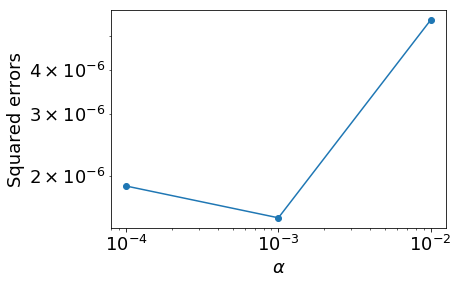

In [15]:
plt.plot(alphas, se_alpha, marker='o')
plt.xlabel(r'$\alpha$')
plt.ylabel('Squared errors')
plt.xscale('log')
plt.yscale('log')
#plt.legend(loc='best')

In [17]:
# OK, let us alpha = 0.1.
# An optimal value can be estimated by the elbow method (refer to the SpM paper by J. Otsuki et al.)
#alpha_best = 0.1
#opt_alpha_idx = -1
alpha_best = alphas[opt_alpha_idx]
print("best value of alpha", alpha_best)
#alpha_best = 0.1

coeffs = coeffs_alpha[opt_alpha_idx].reshape((3, 2, 2, Nl, Nl))
#print(coeffs.shape)

best value of alpha 0.0001


In [18]:
# prj: [(n_sp, 3, 2, 2, Nl), (n_sp, 3, 2, 2, Nl)]
def compute_Giwn(prj, coeff):
    niw = prj[0].shape[0]
    #print(prj[0].shape)
    prj_mat = numpy.einsum('nrl,nrm->nrlm', prj[0], prj[1]).reshape((niw, 3 * 2 * 2 * Nl * Nl))
    return prj_mat@coeffs.reshape((3 * 2 * 2 * Nl * Nl))

Giwn_check = compute_Giwn(prj_check, coeffs)
print(Giwn_check.shape)
Giwn_check_ref = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in n1n2_check])

diff = numpy.amax(numpy.abs(Giwn_check - Giwn_check_ref))
print(diff)
print(diff < 1e-3)

(3600,)
0.004546071909573176
False


[-0.00014741  0.01444247 -0.00239876 ...  0.00595002 -0.00105249
  0.00039686]


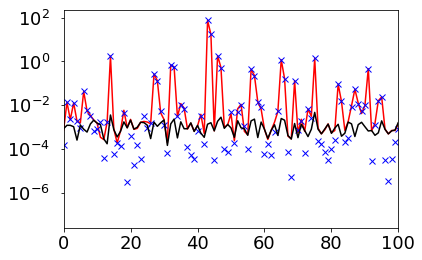

In [19]:
Giwn_reconst = compute_Giwn(prj, coeffs)
#plt.plot(Giwn_reconst.real, c='r')
#plt.plot(Giwn.real)
plt.plot(numpy.abs(Giwn_reconst), c='r')
plt.plot(numpy.abs(Giwn), c='b', ls='', marker='x')
plt.plot(numpy.abs(Giwn-Giwn_reconst), c='k', ls='-', marker='')
plt.yscale("log")
plt.xlim([0,100])
print(Giwn.real)

74.99793370740001


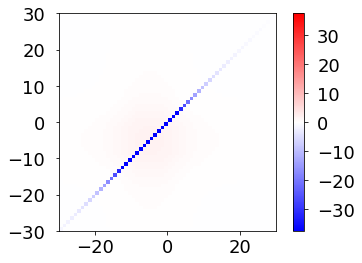

In [21]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

N = 100
N_zoom = 30
#x = numpy.linspace(-N, N, 2*N+1)
x = numpy.arange(-N, N+1)
G2_conn_ph = numpy.zeros((2 * N + 1,2 * N + 1), dtype=float)

for i in range(2 * N + 1):
    for j in range(2 * N + 1):
        n = x[i]
        np = x[j]
        G2_conn_ph[i, j] = _G2_conn_ph(U, beta, n, np, boson_freq)

vrange = numpy.amax(numpy.abs(G2_conn_ph))
plt.imshow(G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()
print (vrange)

#plt.legend(loc='best',shadow=True,frameon=False)

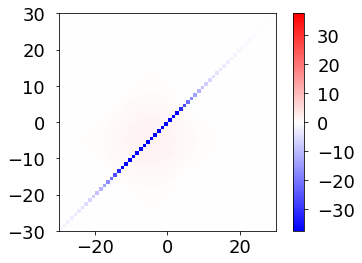

In [22]:
n1n2_check_2d = numpy.array([(x[i], x[j]) for i in range(2 * N + 1) for j in range(2 * N + 1)])
prj_check_2d = construct_prj(n1n2_check_2d)

Giwn_check = compute_Giwn(prj_check_2d, coeffs)
Giwn_check = Giwn_check.reshape((2 * N + 1, 2 * N + 1))
vrange = numpy.amax(numpy.abs(Giwn_check))
plt.imshow(Giwn_check.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()

-5325.800640697531


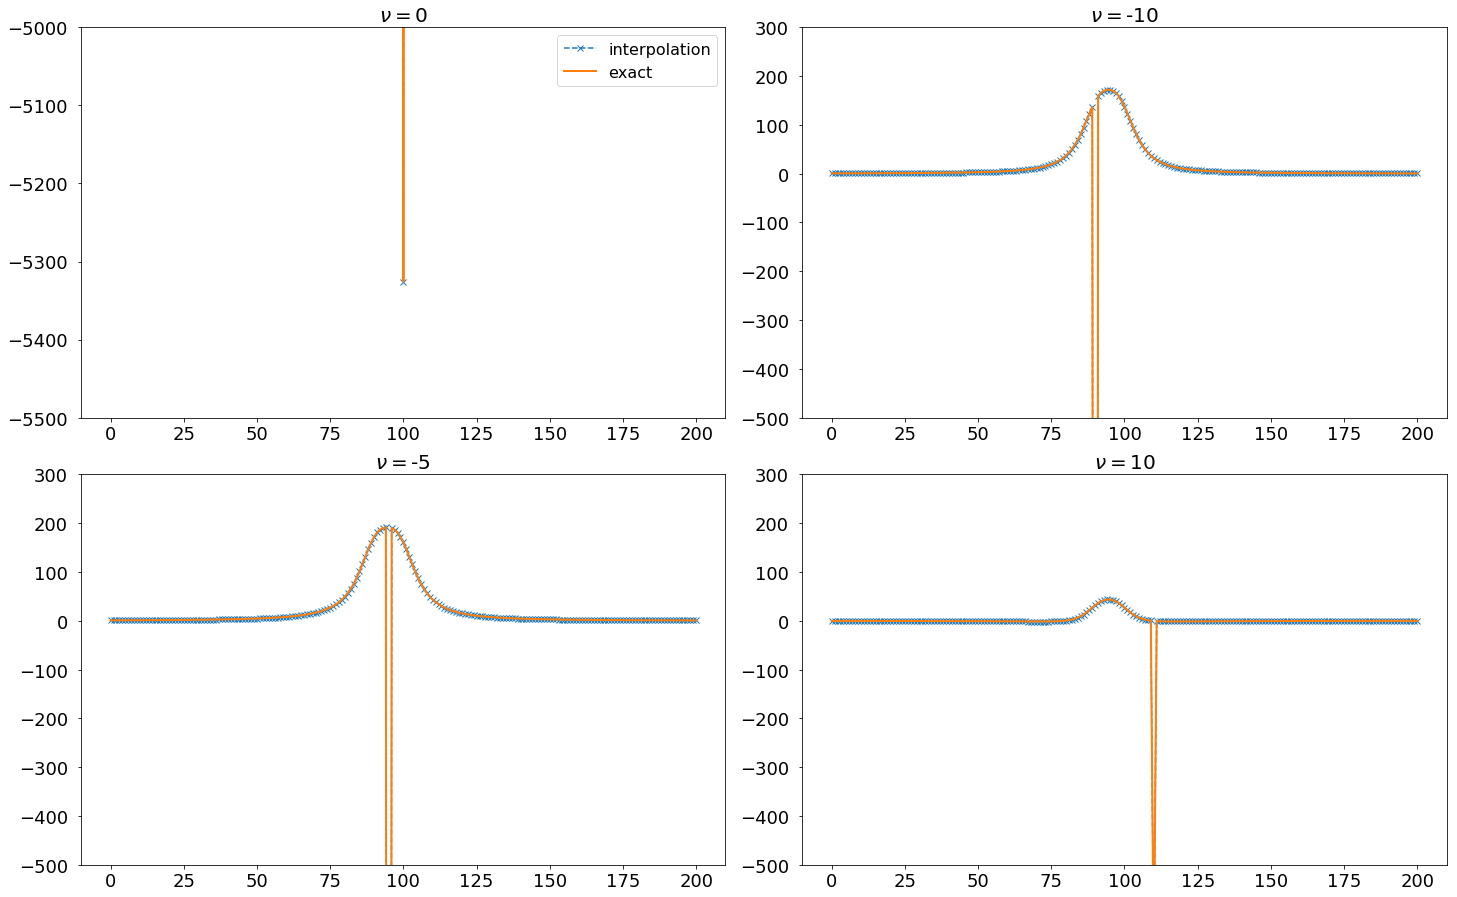

In [37]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-5500, -5000])
print(scale_factor * numpy.amin(G2_conn_ph.real.T[:, N + nu_value]))
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-500, 300])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-500, 300])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-500, 300])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_wide.pdf")

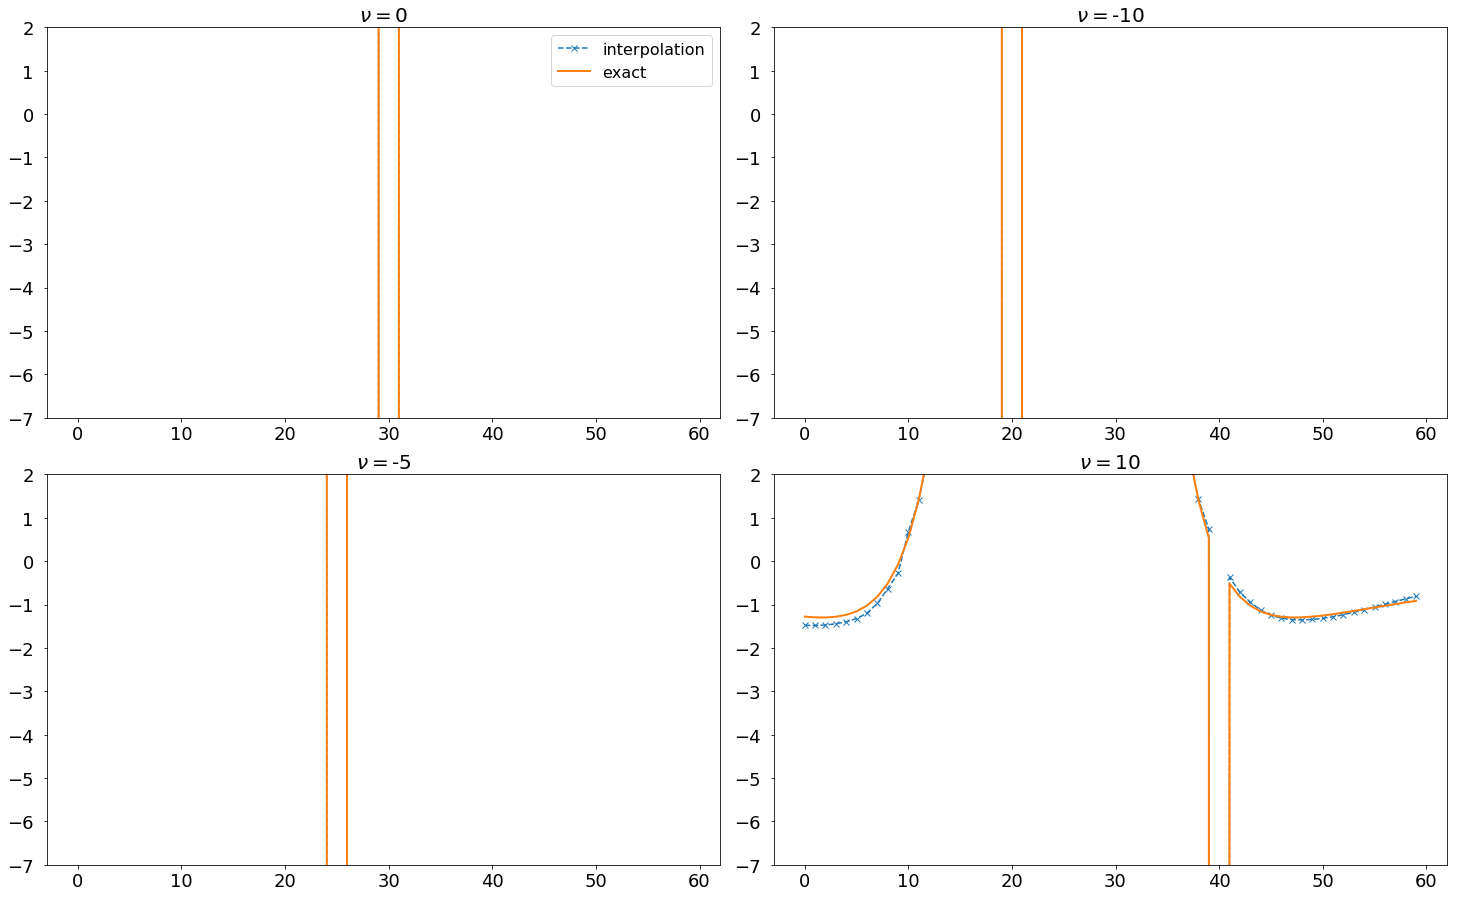

In [24]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_zoom.pdf")